In [1]:
import sys
sys.path.append("../retrieval/")

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
import pandas as pd
from retrieval.models.net import RetrievalNet
from retrieval.engine.get_knn import get_knn
from tqdm import tqdm
import numpy as np

In [3]:
data_dir = "../data/train10k/"
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_path = "experiments/ROADMAP/GLDv2_ROADMAP_128/weights/rolling.ckpt"
state_dict = torch.load(weights_path)

In [4]:
state_dict.keys()

dict_keys(['net_state', 'optimizer_state', 'scheduler_on_epoch_state', 'scheduler_on_step_state', 'scheduler_on_val_state', 'scaler_state', 'epoch', 'seed', 'config', 'score', 'best_score', 'best_model', 'RANDOM_STATE', 'NP_STATE', 'TORCH_STATE', 'TORCH_CUDA_STATE'])

In [5]:
print(
    f"SEED: {state_dict['seed']}\n"
    f"Epoch: {state_dict['epoch']}\n"
    f"Score: {state_dict['score']}\n"
    f"Best_score: {state_dict['best_score']}\n"
    f"Best_model: {state_dict['best_model']}\n"
    # f"Config: {state_dict['config']}\n"
)

SEED: 42
Epoch: 150
Score: 0.45488193540770266
Best_score: 0.45488193540770266
Best_model: epoch_150.ckpt



In [6]:
weights = state_dict["net_state"]
net = RetrievalNet(
    "vit_deit_distilled",
    embed_dim=384,
    norm_features=False,
    without_fc=True,
    with_autocast=False,
    pooling='default',
    projection_normalization_layer='none',
    pretrained=False,
)
net.load_state_dict(weights)
net.to(device)
net.eval()

RetrievalNet(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (d

In [7]:
infer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_embedding(img):
    with torch.no_grad():
        return net(
            infer_transform(img).unsqueeze(0).to(device)
        )

In [8]:
def img_path_from_id(id, data_dir):
    img_path = os.path.join(data_dir, id[0], id[1], id[2], f"{id}.jpg")
    return img_path

csv_path = "../data/train10k.csv"

df = pd.read_csv(csv_path)
pths = [img_path_from_id(img_id, data_dir) for img_id in df["id"].values]
lbls = df["landmark_id"].values

sorted_lb = list(sorted(set(lbls)))
set_labels = set(sorted_lb[int(-0.2 * len(sorted_lb)):])

paths = []
labels = []
for lb, pth in zip(lbls, pths):
    if lb in set_labels:
        paths.append(pth)
        labels.append(lb)

In [9]:
len(paths)

39831

In [10]:
# plt.bar(range(2000), pd.Series(labels).value_counts().values)

In [11]:
# img = Image.open(paths[0]).convert('RGB')
# input = infer_transform(img).unsqueeze(0)
# input = input.to(device)
# emb = net(input)

In [12]:
# emb.shape

In [13]:
def get_embeddings(img_paths):
    with torch.no_grad():
        embeddings = [
            get_embedding(Image.open(img_path).convert("RGB"))[0].cpu().numpy()
            for img_path in tqdm(img_paths)
        ]
    return np.stack(embeddings)

In [14]:
embeddings = get_embeddings(paths[:])

100%|██████████| 39831/39831 [08:57<00:00, 74.16it/s]


In [21]:
base_embeddings = []
query_embeddings = []
query_labels = []
base_labels = []
query_paths = []
base_paths = []
labels_set = set()
for embedding, label, path in tqdm(zip(embeddings, labels, paths), total=len(labels)):
    if label not in labels_set:
        labels_set.add(label)
        query_embeddings.append(embedding)
        query_labels.append(label)
        query_paths.append(path)
    else:
        base_embeddings.append(embedding)
        base_labels.append(label)
        base_paths.append(path)

base_embeddings = np.stack(base_embeddings)
query_embeddings = np.stack(query_embeddings)

100%|██████████| 39831/39831 [00:00<00:00, 1521676.33it/s]


In [20]:
base_embeddings.shape, query_embeddings.shape

((37831, 384), (2000, 384))

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [16]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings)
x = pca_result[:,0]
y = pca_result[:,1]
z = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.04361283 0.03859566 0.02854423]


In [17]:
pca_df = pd.DataFrame(zip(x, y, z, labels), columns=["x", "y", "z", "label"])

In [18]:
pca_df

,x,y,z,label
0,-0.113916,-0.171355,0.121138,202272
1,-0.062584,-0.127456,0.123630,202272
2,-0.228871,-0.030743,0.029209,202272
3,-0.136444,-0.072096,0.120672,202272
4,-0.158210,-0.004988,0.192243,202272
...,...,...,...,...
39826,-0.053755,0.263564,-0.030465,174276
39827,0.004841,0.353718,0.012598,174276
39828,0.192361,-0.052984,0.136634,168994
39829,0.166021,-0.079452,0.155920,168994


<AxesSubplot:xlabel='x', ylabel='y'>

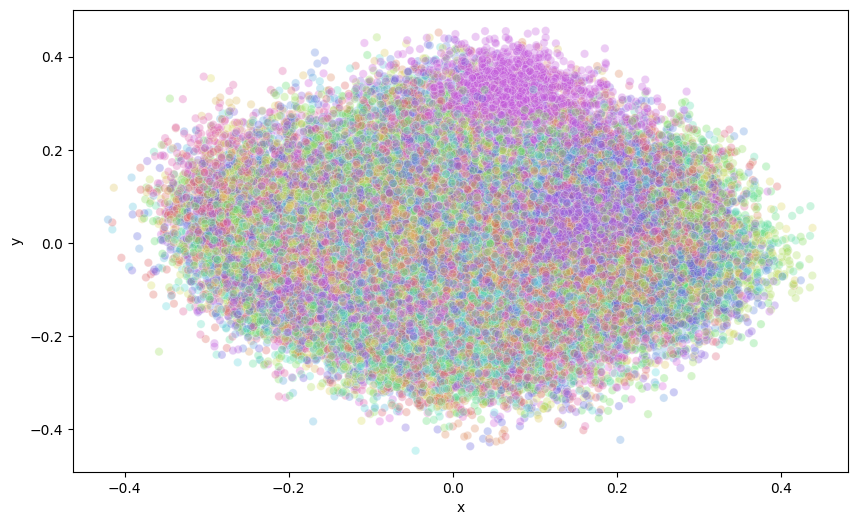

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", pca_df.label.nunique()),
    data=pca_df,
    legend=False, #"full",
    alpha=0.3
)

In [31]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(zip(tsne_results[:,0], tsne_results[:,1], labels), columns=["x", "y", "label"])

/home/and/miniforge3/envs/landmarks/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/and/miniforge3/envs/landmarks/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 39831 samples in 0.013s...
[t-SNE] Computed neighbors for 39831 samples in 28.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39831
[t-SNE] Computed conditional probabilities for sample 2000 / 39831
[t-SNE] Computed conditional probabilities for sample 3000 / 39831
[t-SNE] Computed conditional probabilities for sample 4000 / 39831
[t-SNE] Computed conditional probabilities for sample 5000 / 39831
[t-SNE] Computed conditional probabilities for sample 6000 / 39831
[t-SNE] Computed conditional probabilities for sample 7000 / 39831
[t-SNE] Computed conditional probabilities for sample 8000 / 39831
[t-SNE] Computed conditional probabilities for sample 9000 / 39831
[t-SNE] Computed conditional probabilities for sample 10000 / 39831
[t-SNE] Computed conditional probabilities for sample 11000 / 39831
[t-SNE] Computed conditional probabilities for sample 12000 / 39831
[t-SNE] Computed conditional probabilities for s

In [32]:
tsne_df.shape, tsne_df.label.nunique()

((39831, 3), 2000)

In [37]:
import plotly.express as px
fig = px.scatter(
    tsne_df, #[tsne_df.label == 164191], 
    x="x", y="y", color="label",
)
fig.show()

<AxesSubplot:xlabel='x', ylabel='y'>

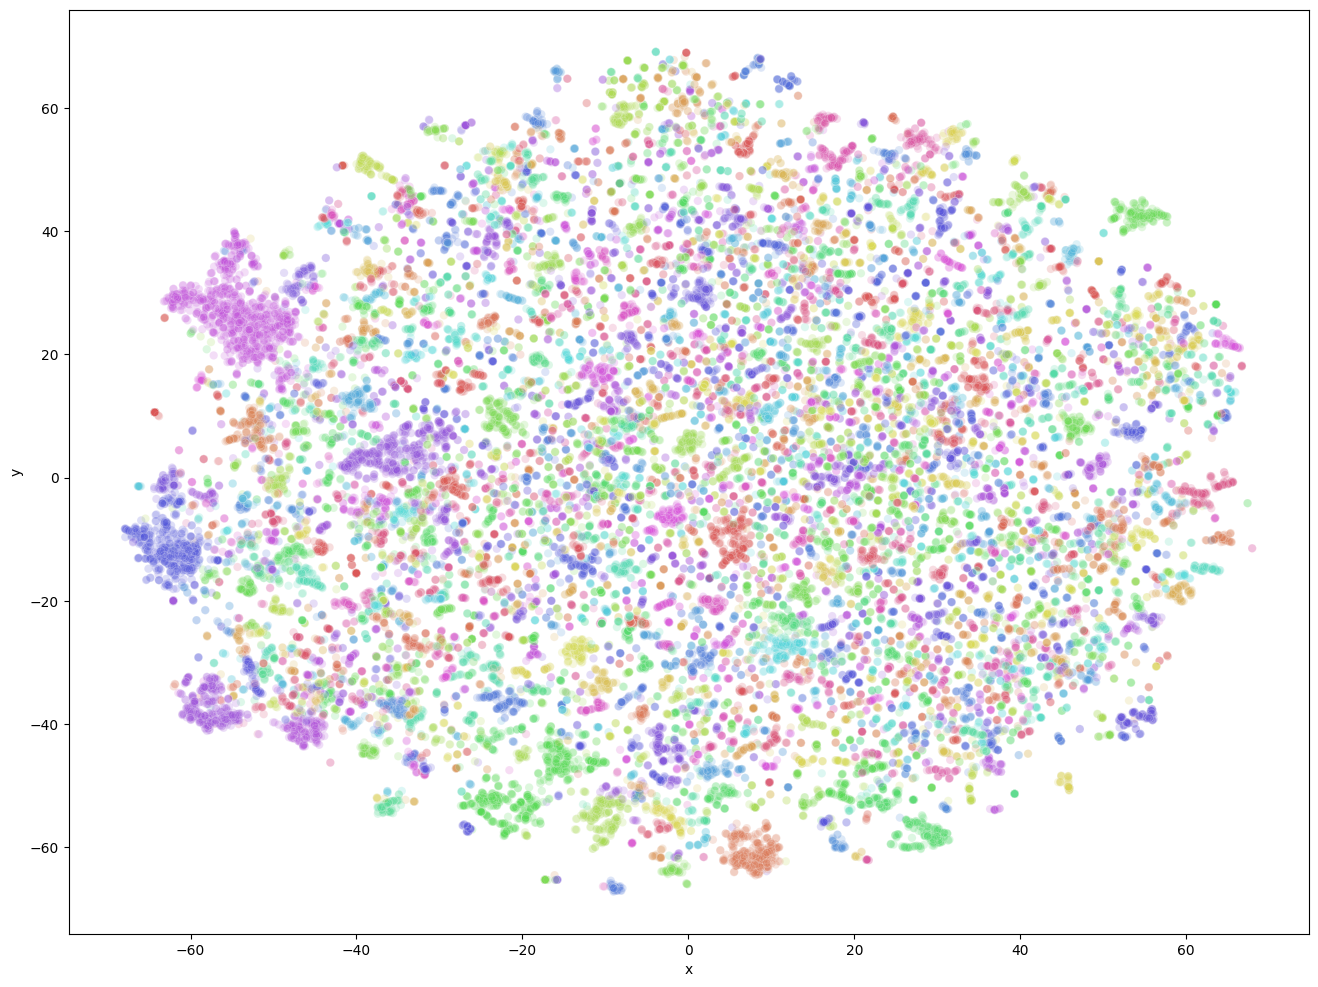

In [35]:
plt.figure(figsize=(16,12))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", tsne_df.label.nunique()),
    data=tsne_df[:],
    legend=False, #"full",
    alpha=0.2
)

In [80]:
def plot_sim(query_imgs, query_labels, knn_indices, knn_distances):
    num_rows, num_cols = len(knn_indices), len(knn_indices[0])
    fig, axes = plt.subplots(num_rows, num_cols + 1, figsize=(16, 8))

    for j in range(num_rows):
        axes[j, 0].imshow(query_imgs[j])
        axes[j, 0].axis('off')
        axes[j, 0].set_title(f'Query: {query_labels[j]}')

        for i in range(num_cols):
            idx = knn_indices[j][i]
            axes[j, i + 1].imshow(Image.open(base_paths[idx]).convert("RGB"))
            axes[j, i + 1].axis('off')
            axes[j, i + 1].set_title(f'{base_labels[idx]}: {knn_distances[j][i]:.3f}')


def find_similar(query_idxs, references, num_k=5):
    references = torch.from_numpy(references)

    query_imgs, query_lbls, query_embs = [], [], []
    for idx in query_idxs:
        query_imgs.append(Image.open(query_paths[idx]).convert("RGB"))
        query_lbls.append(query_labels[idx])
        query_embs.append(query_embeddings[idx])

    query_embs = torch.as_tensor(query_embs)


    # query_img = Image.open(query_paths[query_idx]).convert("RGB")
    # query_label = query_labels[query_idx]
    # query_embedding = torch.from_numpy(query_embeddings[query_idx][np.newaxis])


    knn_indices_batch, knn_distances_batch = get_knn(
        references,
        query_embs,
        num_k,
        embeddings_come_from_same_source=False,
        with_faiss=False,
    )
    # reference_images, reference_labels = [[] for i in range(num_k)], [[] for i in range(num_k)]
    # for knn_indices in knn_indices_batch.tolist():
    #     for idx in knn_indices:
    #     reference_images.append(Image.open(base_paths[idx]).convert("RGB"))
    #     reference_labels.append(base_labels[idx])

    plot_sim(query_imgs, query_lbls, knn_indices_batch.tolist(), knn_distances_batch.tolist())

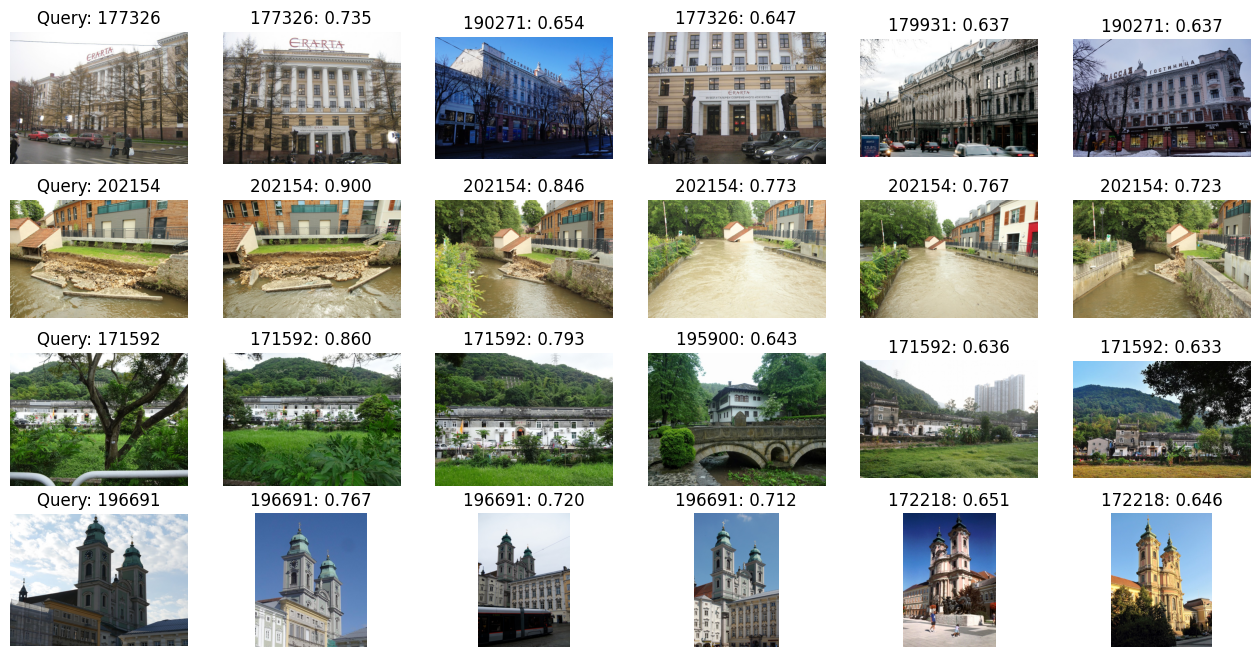

In [85]:
find_similar(
    query_idxs=np.random.choice(range(0, len(query_paths)), size=4),
    references=base_embeddings,
    num_k=5
)